# psd_cs_ccf.ipynb
Abbie Stevens (<abigailstev@gmail.com>), 2022

In [1]:
import numpy as np
import os
from datetime import datetime
import warnings
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray import Powerspectrum, AveragedPowerspectrum, AveragedCrossspectrum, CrossCorrelation
from scipy.fftpack import ifft
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
homedir = os.path.expanduser('~')
exe_dir = os.getcwd()
obj_name = "Swift_J0243.6+6124"
obj_prefix = "J0243"
data_dir = '%s/Reduced_data/%s/' % (homedir, obj_name)
listdir = "%s/Documents/Research/%s/in" % (homedir, obj_prefix)
assert os.path.isdir(data_dir)
data_file = "%sobs113_bary.evt" % (data_dir)
assert os.path.isfile(data_file)

In [3]:
dt = 1./2.
n_seconds = int(64)  # length of light curve segment, in seconds
broad_le = 0.2
broad_he = 12.
ref_le = 0.2
ref_he = 12.
b1_le = 0.2  # keV
b1_he = 1.  # keV
b2_le = 1.  # keV
b2_he = 2.  # keV
b3_le = 2.  # keV
b3_he = 3.  # keV
hard_le = 3.  # keV
hard_he = 12.  # keV

ps_out_file = "%s/out/%s_%dsec_%ddt_psd-cs.fits" % (exe_dir, obj_prefix, n_seconds, int(1/dt))
ccf_out_file = "%s/out/%s_%dsec_%ddt_ccf.fits" % (exe_dir, obj_prefix, n_seconds, int(1/dt))

In [4]:
datatab = Table.read(data_file, format='fits', hdu=1)
## All MPUs, 0.2-12 keV
broad_mask = (datatab['PI'] >= int(broad_le*100)) & \
             (datatab['PI'] <= int(broad_he*100))
datatab = datatab[broad_mask]

In [5]:
gtitab = Table.read(data_file, format='fits', hdu=2)
print(gtitab)
gtis = [[i,j] for i,j in zip(gtitab['START'], gtitab['STOP'])]

      START               STOP       
        s                  s         
------------------ ------------------
120970834.86620812 120971402.88879049
120971407.88897188 120971419.88940565
120976626.02114478 120976980.03472188
120992868.43637262 120992869.43641537
120992871.43650085 120993723.97255741
120993723.97304083 120993757.95188123
120993757.95422462 120993920.47681308
121009532.86550564 121010600.90631835
121015087.00767943 121016024.04429896
121016027.04439765 121016040.04482351


## Masking for event list selections
Use masks to select the energies and detectors for analysis

In [6]:
## MPUs 0-3 are CI
## MPUs are marked by the 1st digit (0-6 incl) in the detector ID
ci_mask = datatab['DET_ID'] < 40
evts_ci = datatab[ci_mask]

## MPUs 4-6 are REF (i.e., the other ones that aren't CI)
evts_ref = datatab[~ci_mask]
## Also want ref to be 0.2-12 keV
ref_mask = (evts_ref['PI'] >= int(ref_le*100)) & \
           (evts_ref['PI'] <= int(ref_he*100))
evts_ref = evts_ref[ref_mask]

In [7]:
## All MPUs, soft band 1
b1_mask = (datatab['PI'] >= int(b1_le*100)) & \
          (datatab['PI'] < int(b1_he*100))
evts_b1 = datatab[b1_mask]

## All MPUs, soft band 2
b2_mask = (datatab['PI'] >= int(b2_le*100)) & \
          (datatab['PI'] < int(b2_he*100))
evts_b2 = datatab[b2_mask]

## All MPUs, soft band 3
b3_mask = (datatab['PI'] >= int(b3_le*100)) & \
          (datatab['PI'] < int(b3_he*100))
evts_b3 = datatab[b3_mask]

## All MPUs, hard band
hard_mask = (datatab['PI'] >= int(hard_le*100)) & \
            (datatab['PI'] <= int(hard_he*100))
evts_hard = datatab[hard_mask]

## Reference band
Make light curve and average power spectrum.

In [8]:
lc_ref = Lightcurve.make_lightcurve(evts_ref['TIME'], dt=dt, gti=gtis)
ps_ref = AveragedPowerspectrum(lc_ref, segment_size=n_seconds, norm='abs')
ci_tstart = lc_ref.tstart
ci_tstop = lc_ref.tseg
print(ci_tstart)
print(ci_tstop)

120970834.86622687
45205.0


## Broad band

In [9]:
lc_broad = Lightcurve.make_lightcurve(datatab['TIME'], dt=dt, gti=gtis)
ps_broad = AveragedPowerspectrum(lc_broad, segment_size=n_seconds, norm='abs')

## Band 1
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [10]:
lc_b1 = Lightcurve.make_lightcurve(evts_b1['TIME'], dt=dt, gti=gtis)
ps_b1 = AveragedPowerspectrum(lc_b1, segment_size=n_seconds, norm='abs')
cs_b1 = AveragedCrossspectrum(lc_b1, lc_ref, segment_size=n_seconds, norm='abs')

## Band 2
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [11]:
lc_b2 = Lightcurve.make_lightcurve(evts_b2['TIME'], dt=dt, gti=gtis)
ps_b2 = AveragedPowerspectrum(lc_b2, segment_size=n_seconds, norm='abs')
cs_b2 = AveragedCrossspectrum(lc_b2, lc_ref, segment_size=n_seconds, norm='abs')

## Band 3
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [12]:
lc_b3 = Lightcurve.make_lightcurve(evts_b3['TIME'], dt=dt, gti=gtis)
ps_b3 = AveragedPowerspectrum(lc_b3, segment_size=n_seconds, norm='abs')
cs_b3 = AveragedCrossspectrum(lc_b3, lc_ref, segment_size=n_seconds, norm='abs')

## Hard band
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [13]:
lc_hard = Lightcurve.make_lightcurve(evts_hard['TIME'], dt=dt, gti=gtis)
ps_hard = AveragedPowerspectrum(lc_hard, segment_size=n_seconds, norm='abs')
cs_hard = AveragedCrossspectrum(lc_hard, lc_ref, segment_size=n_seconds, norm='abs')

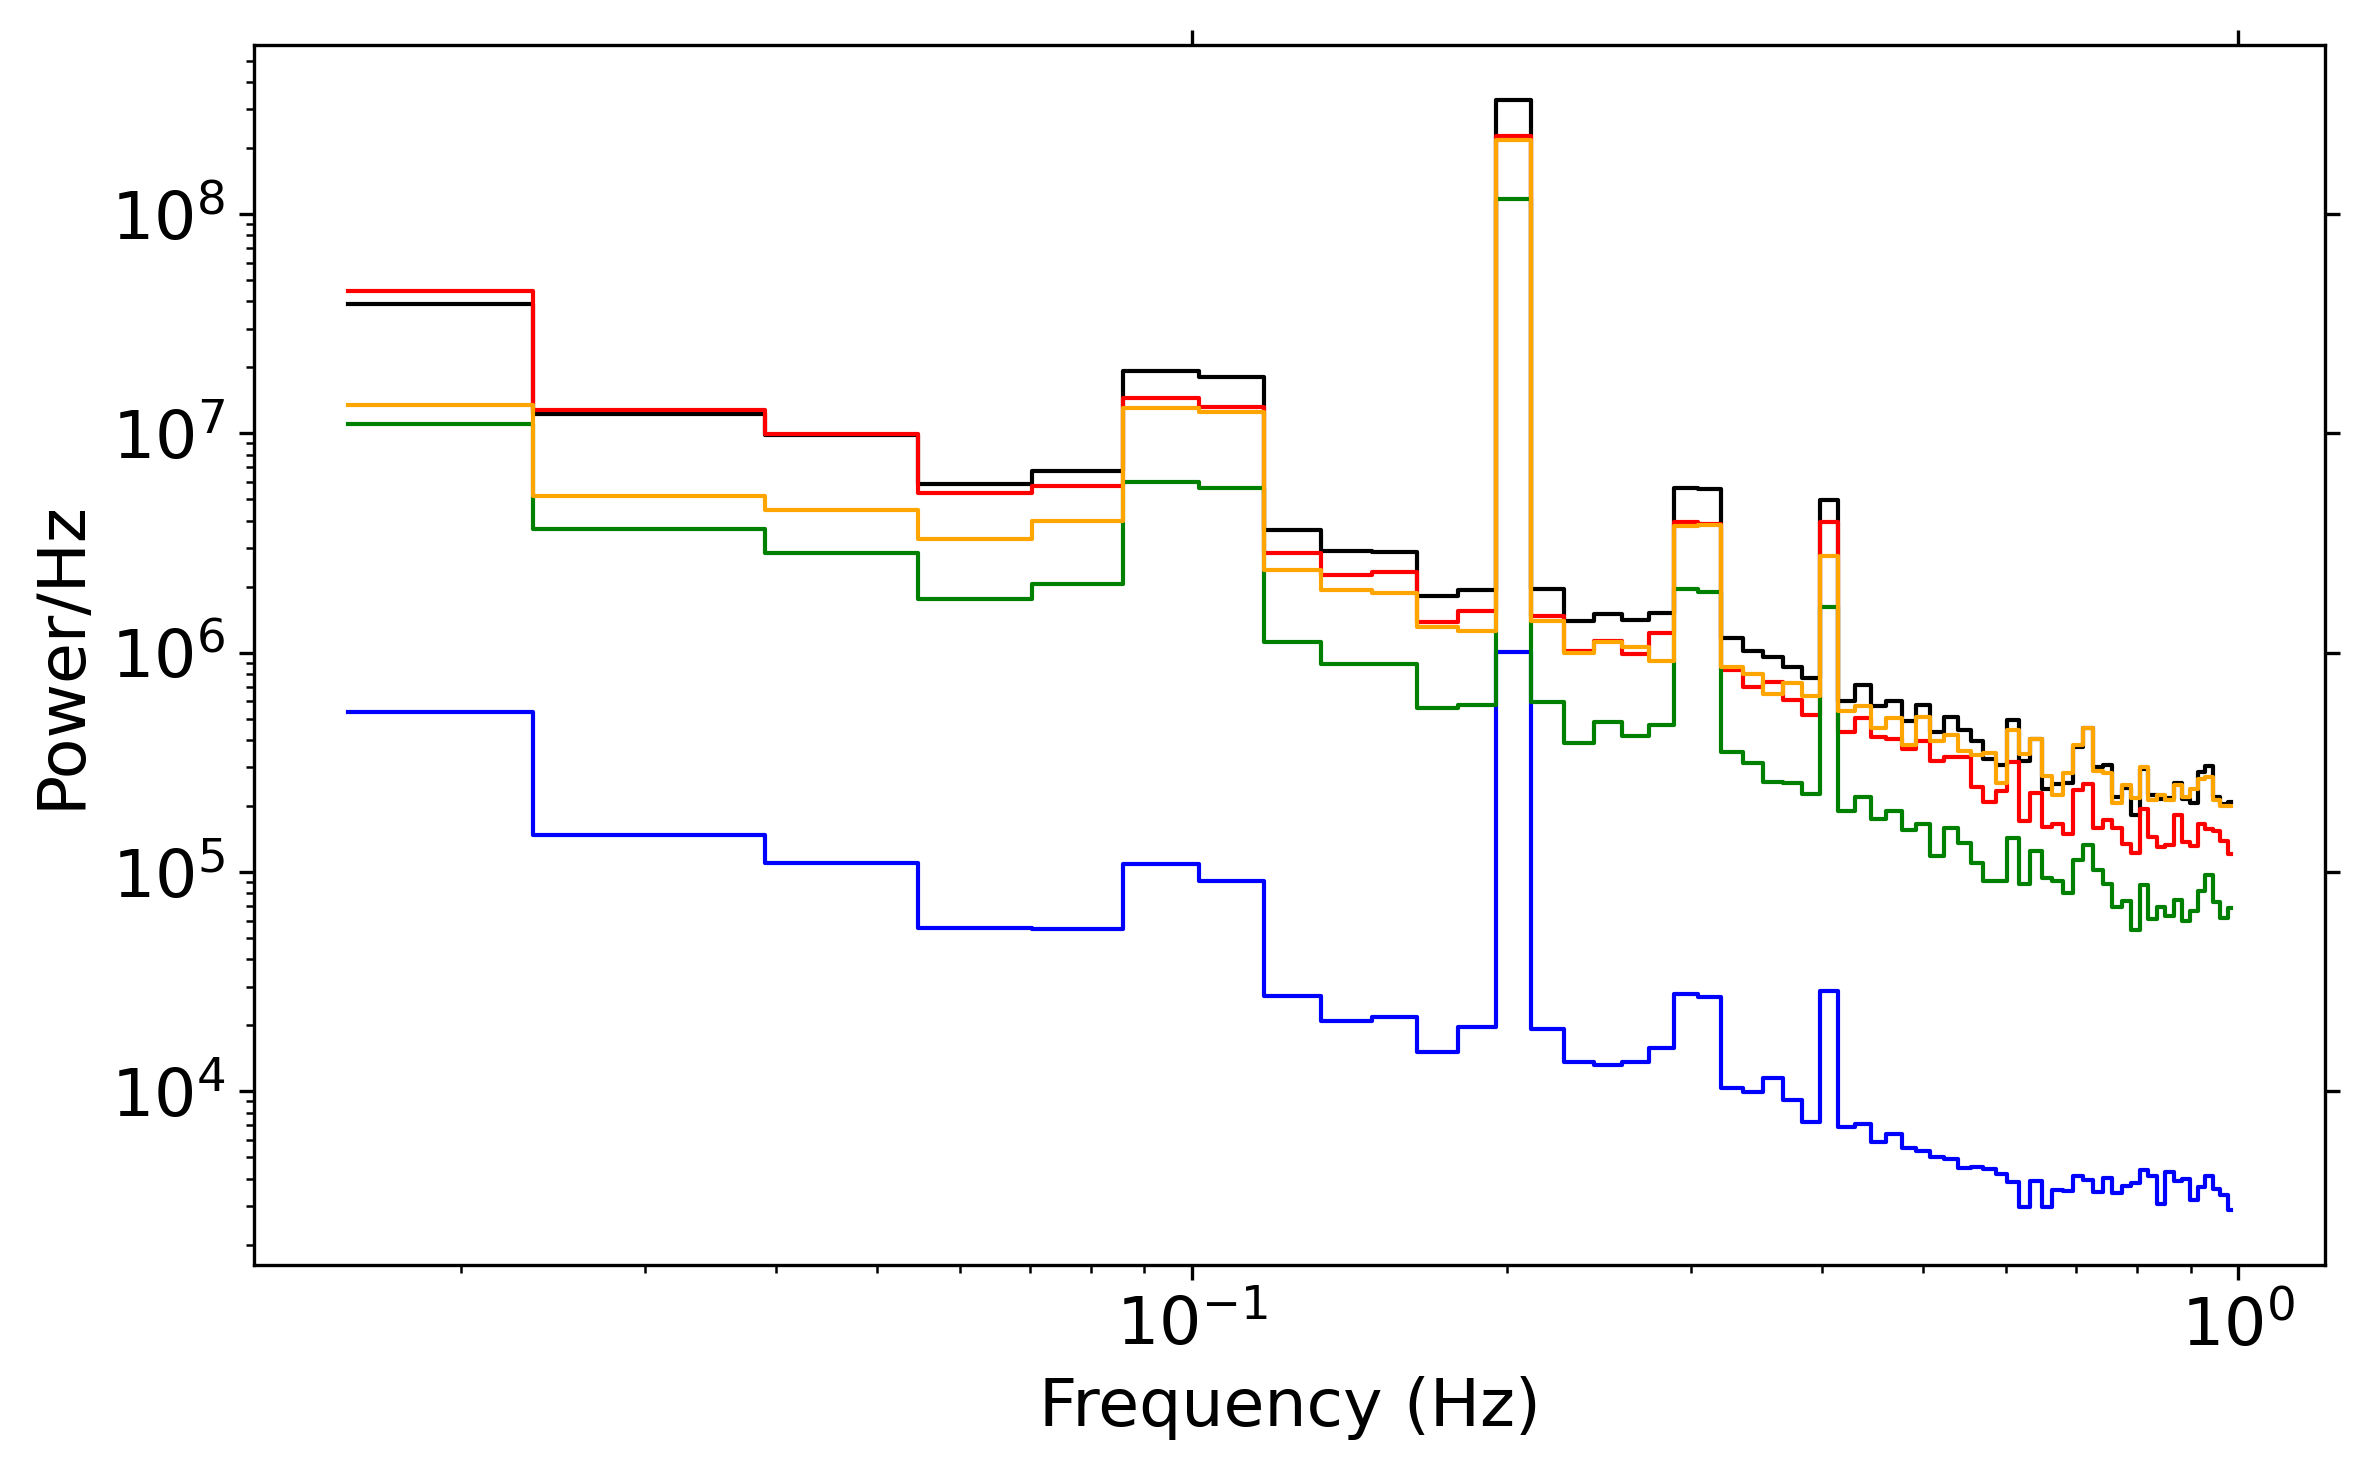

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps_ref.freq, ps_ref.power, lw=1, drawstyle='steps-mid', color='black')
ax.plot(ps_b1.freq, ps_b1.power, lw=1, drawstyle='steps-mid', color='blue')
ax.plot(ps_b2.freq, ps_b2.power, lw=1, drawstyle='steps-mid', color='red')
ax.plot(ps_b3.freq, ps_b3.power, lw=1, drawstyle='steps-mid', color='green')
ax.plot(ps_hard.freq, ps_hard.power, lw=1, drawstyle='steps-mid', color='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

# Saving the power spectra and cross spectra 
Broad, ref, b1, b2, b3, and hard. Haven't done CI yet!

In [15]:
dets = np.unique(evts_b1['DET_ID'])

In [16]:
tab_ps = Table()
tab_ps.add_column(Column(name="FREQUENCY", data=ps_ref.freq, unit="Hz",
                         dtype='float32', description="Fourier frequency"))

tab_ps.add_column(Column(name="PSD_BROAD", data=ps_broad.power, dtype='float64',
                         description="PSD of all MPUs in rms^2 units, %.2f-%.2f keV, "\
                                     "w Poiss noise" % (broad_le, broad_he)))

tab_ps.add_column(Column(name="PSD_REF", data=ps_ref.power, dtype='float64',
                         description="Ref power spectrum in rms^2 units, %.2f-%.2f keV, "\
                                     "w Poiss noise" % (ref_le, ref_he)))

tab_ps.add_column(Column(name="PSD_B1", data=ps_b1.power, dtype='float64',
                         description="PSD of soft band 1, w Poiss noise in rms^2 units"))

tab_ps.add_column(Column(name="PSD_B2", data=ps_b2.power, dtype='float64',
                         description="PSD of soft band 2, w Poiss noise in rms^2 units"))

tab_ps.add_column(Column(name="PSD_B3", data=ps_b3.power, dtype='float64',
                         description="PSD of soft band 3, w Poiss noise in rms^2 units"))

tab_ps.add_column(Column(name="PSD_HARD", data=ps_hard.power, dtype='float64',
                         description="PSD of hard band, w Poiss noise in rms^2 units"))

tab_ps.add_column(Column(name="CS_B1", data=cs_b1.power, dtype='c16',
                         description="CS of hard band w soft band 1 in rms^2 units"))

tab_ps.add_column(Column(name="CS_B2", data=cs_b2.power, dtype='c16',
                         description="CS of hard band w soft band 2 in rms^2 units"))

tab_ps.add_column(Column(name="CS_B3", data=cs_b3.power, dtype='c16',
                         description="CS of hard band w soft band 3 in rms^2 units"))

file_type = "No deadtime or bkgd corrections"
tab_ps.meta['OBJECT'] = obj_name
tab_ps.meta['INST'] = "NICER"
tab_ps.meta['TODAY'] = str(datetime.now())
tab_ps.meta['TYPE'] = file_type
tab_ps.meta['INFILE'] = data_file
tab_ps.meta['EXPOSURE'] = ps_ref.segment_size * ps_ref.m
tab_ps.meta['N_BINS'] = ps_ref.n
tab_ps.meta['DT'] = lc_ref.dt
tab_ps.meta['DF'] = ps_ref.df
tab_ps.meta['N_SEG'] = ps_ref.m
tab_ps.meta['N_SECOND'] = ps_ref.segment_size
tab_ps.meta['NYQUIST'] = 1./(2.*dt)
tab_ps.meta['DETS'] = str(dets.tolist())
tab_ps.meta['RATE_REF'] = lc_ref.meanrate
tab_ps.meta['RANGE_BR'] = "%.2f-%.2f-keV" % (broad_le, broad_he)
tab_ps.meta['RATE_BR'] = lc_broad.meanrate
tab_ps.meta['RATE_REF'] = lc_ref.meanrate
tab_ps.meta['RANGE_B1'] = "%.2f-%.2f-keV" % (b1_le, b1_he)
tab_ps.meta['RATE_B1'] = lc_b1.meanrate
tab_ps.meta['RANGE_B2'] = "%.2f-%.2f-keV" % (b2_le, b2_he)
tab_ps.meta['RATE_B2'] = lc_b2.meanrate
tab_ps.meta['RANGE_B3'] = "%.2f-%.2f-keV" % (b3_le, b3_he)
tab_ps.meta['RATE_B3'] = lc_b3.meanrate
tab_ps.meta['RANGE_HA'] = "%.2f-%.2f-keV" % (hard_le, hard_he)
tab_ps.meta['RATE_HA'] = lc_hard.meanrate

tab_ps.write(ps_out_file, format='fits', overwrite=True)
print("Output saved to: %s \n" % ps_out_file)

Output saved to: /home/astevens/Documents/Research/J0243/out/J0243_64sec_2dt_psd-cs.fits 



## Channels of interest ("CI")
Make individual light curves and cross spectra of each narrow energy channel of interest with the reference band. 

In [17]:
## We're binning up the PI info into 294 energy channels
binning_file = exe_dir + "/in/chbinfile-6.txt"
assert os.path.isfile(binning_file), "Chbinfile not found: %s" % binning_file
binning = np.loadtxt(binning_file, dtype=int)
print("Binning from file: %s" % binning_file)
chan_bins = np.asarray([], dtype=int)
c = 0  # channel counter to load the binning
for grp in binning:
    if grp[2] != -1:
        for c in range(grp[0], grp[1] + 1, grp[2]):
            chan_bins = np.append(chan_bins, c)
chan_bins = np.append(chan_bins, c + binning[-2, 2])  ## End of the last bin
n_chans = len(chan_bins)-1
# print(chan_bins)
# print(n_chans)

Binning from file: /home/astevens/Documents/Research/J0243/in/chbinfile-6.txt


In [18]:
ci_dets = np.unique(evts_ci['DET_ID'])
n_bins = int(n_seconds/dt)

### FYI: this next cell takes a few minutes to run!

In [19]:
ps_ci = np.asarray([])
cs_ci = np.asarray([])
mean_ci = np.asarray([])
# n_chans = 3
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore", category=UserWarning)
    for i in range(n_chans):
        this_ci_mask = (evts_ci['PI'] >= chan_bins[i]) & (evts_ci['PI'] < chan_bins[i+1])
        evts_this = evts_ci[this_ci_mask]
        lc_this = Lightcurve.make_lightcurve(evts_this['TIME'], dt=dt, gti=gtis, tstart=ci_tstart, tseg=ci_tstop)
        mean_ci = np.append(mean_ci, lc_this.meanrate)
        ps_this = AveragedPowerspectrum(lc_this, segment_size=n_seconds, norm='abs')
        ps_ci = np.append(ps_ci, ps_this)
        cs_this = AveragedCrossspectrum(lc_this, lc_ref, segment_size=n_seconds, norm='none', fullspec=True, save_all=True)
#         cs_this = AveragedCrossspectrum(lc_this, lc_ref, segment_size=n_seconds, norm='none')
        cs_ci = np.append(cs_ci, cs_this)

INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


INFO:astropy:Using legacy interface.
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


In [20]:
print(mean_ci)

[5.89794897e-01 1.01050525e+00 1.61555778e+00 2.17408704e+00
 2.54177089e+00 2.76238119e+00 2.85342671e+00 2.95422711e+00
 2.94122061e+00 2.94497249e+00 2.93946973e+00 2.97948974e+00
 3.03001501e+00 3.06978489e+00 3.11530765e+00 3.21360680e+00
 3.22686343e+00 3.24962481e+00 3.37068534e+00 3.79814907e+00
 4.69034517e+00 5.87443722e+00 7.46098049e+00 9.26238119e+00
 1.11795898e+01 1.32686343e+01 1.57716358e+01 1.89199600e+01
 2.25775388e+01 2.64944972e+01 3.04769885e+01 3.44017009e+01
 3.75330165e+01 4.04144572e+01 4.26588294e+01 4.64014507e+01
 5.11093047e+01 5.67441221e+01 6.24644822e+01 6.90062531e+01
 7.54529765e+01 8.12183592e+01 8.59539770e+01 9.01198099e+01
 9.43421711e+01 9.77351176e+01 1.01399450e+02 1.04491746e+02
 1.07548024e+02 1.10033767e+02 1.13021261e+02 1.15559530e+02
 1.17695598e+02 1.19448974e+02 1.20853427e+02 1.21707104e+02
 1.22443472e+02 1.23231616e+02 1.24702101e+02 1.26298899e+02
 1.28184842e+02 1.30423462e+02 1.32296648e+02 1.33851426e+02
 1.33905953e+02 1.334982

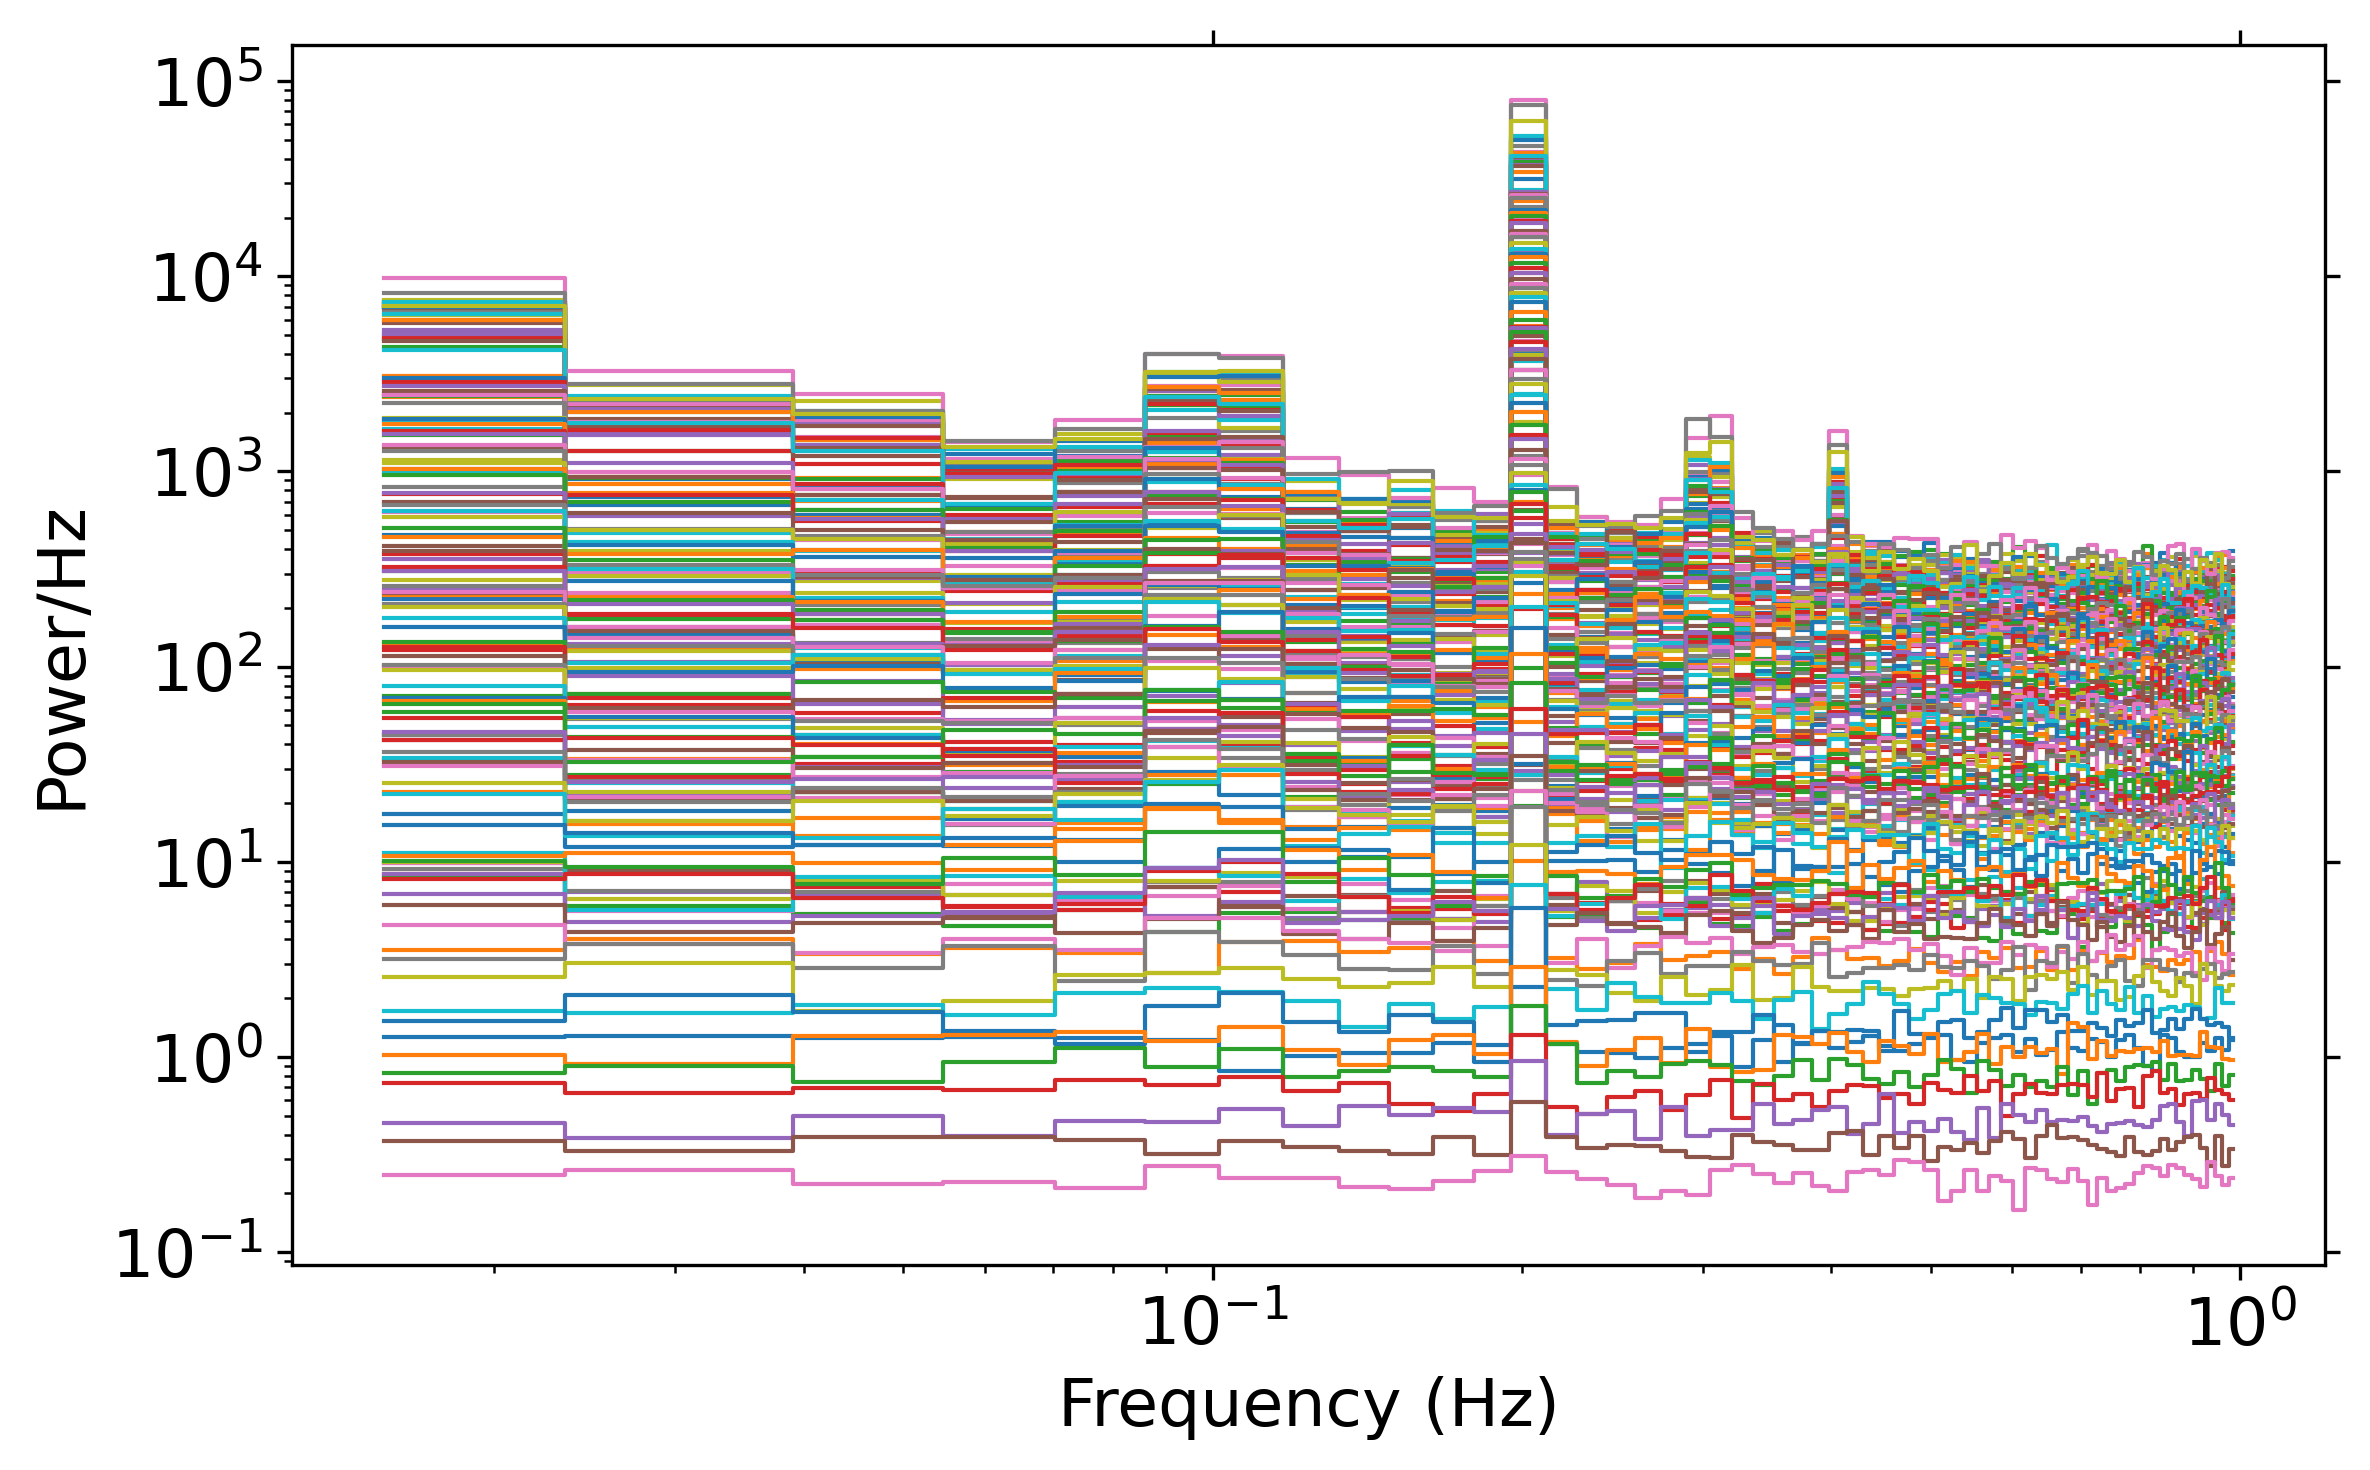

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
# ax.plot(ps_ref.freq, ps_ref.power, lw=1, drawstyle='steps-mid', color='black')
for i in range(0, n_chans, 2):
    ax.plot(ps_ci[i].freq, ps_ci[i].power, lw=1, drawstyle='steps-mid')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

In [22]:
print(np.shape(cs_ci))
print(len(cs_ci[0].cs_all))
print(cs_ci[0].m)
print(np.shape(cs_ci))
print(cs_ci[0].cs_all[1].power[0:5])

(294,)
58
58
(294,)
[ 2.13812640e+07     +0.j          1.68680100e+05 +10292.16841185j
  5.89932866e+04  -1745.339151j   -1.53080893e+05 -91141.41120867j
  1.54895504e+03+103117.97745479j]


In [23]:
ccf_segs = np.zeros((n_chans, cs_ci[0].n, cs_ci[0].m))
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    for i in range(n_chans):
        for j in range(cs_ci[0].m):
            ccf_segs[i,:,j] = ifft(cs_ci[i].cs_all[j].power)
print(np.shape(ccf_segs))

(294, 128, 58)


## Making the ccf from the average cross spectra

In [24]:
# print(cs_ci[i].power)
ccf = np.zeros((ps_ref.n, n_chans))
for i in range(n_chans):
    ccf[:,i] = ifft(cs_ci[i].power)

/tmp/ipykernel_159112/1794996182.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  ccf[:,i] = ifft(cs_ci[i].power)


In [25]:
ccf_segs = np.zeros((ps_ref.n, n_chans, ps_ref.m))
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    for i in range(n_chans):
        for j in range(ps_ref.m):
            assert cs_ci[i].cs_all[j].norm == 'none', "CI cross spectrum normalization needs to be 'none'"
            ccf_segs[:,i,j] = ifft(cs_ci[i].cs_all[j].power)
avg_ccf = np.mean(ccf_segs, axis=2)

In [26]:
# print(ccf[2,2],avg_ccf[2,2])
assert np.isclose(ccf[2,2],avg_ccf[2,2], atol=1e-5), "Check CCF inputs, the results don't match. Diff: %f" % np.diff(ccf[2,2],avg_ccf[2,2])

### Normalize the ccf as in Stevens & Uttley 2016

In [27]:
if ps_ref.norm != "abs":
    ps_ref.norm = 'abs'
ref_rms = np.sqrt(np.sum(ps_ref.power * ps_ref.df))  ## Assuming absolute rms normalization
# divide by the ref band rms and normalize
ccf *= 2.0 / float(ps_ref.n) / ref_rms
ccf_segs *= 2.0 / float(ps_ref.n) / ref_rms

### Standard error on the CCF

In [28]:
## Compute the standard error on each ccf bin from the segment-to-segment variations.
ccf_resid = (ccf_segs.T - ccf.T).T
## Eqn 2.3 from S. Vaughan 2013, "Scientific Inference"
sample_var = np.sum(ccf_resid ** 2, axis=2) / (ps_ref.n - 1)
## Eqn 2.4 from S. Vaughan 2013, "Scientific Inference"
ccf_err = np.sqrt(sample_var / ps_ref.n)

In [29]:
print(np.shape(ccf_err))
print(ccf_err[2,2])
print(ccf[2,2])

(128, 294)
0.04131966807887028
3.1476209815637226


## Save ccf and error to a FITS file

In [30]:
tab_ccf = Table()
tab_ccf.add_column(Column(name="TIMEBINS", data=np.arange(n_bins), unit='bin',
                          dtype='int32', description="CCF time bins"))

tab_ccf.add_column(Column(name="CCF", data=ccf, dtype='float64',
                          unit="ct/s", description="Average CCF from CROSS"))

tab_ccf.add_column(Column(name="CCF_ERR", data=ccf_err, dtype='float64',
                          unit="ct/s", description="Error on CCF"))

file_type = "No deadtime or bkgd corrections"
tab_ccf.meta['OBJECT'] = obj_name
tab_ccf.meta['INST'] = "NICER"
tab_ccf.meta['TODAY'] = str(datetime.now())
tab_ccf.meta['TYPE'] = file_type
tab_ccf.meta['INFILE'] = data_file
tab_ccf.meta['EXPOSURE'] = ps_ref.segment_size * ps_ref.m
tab_ccf.meta['N_BINS'] = ps_ref.n
tab_ccf.meta['DT'] = lc_ref.dt
tab_ccf.meta['DF'] = ps_ref.df
tab_ccf.meta['N_CHANS'] = n_chans
tab_ccf.meta['CHBINFIL'] = binning_file
tab_ccf.meta['N_SEG'] = ps_ref.m
tab_ccf.meta['N_SECOND'] = ps_ref.segment_size
tab_ccf.meta['NYQUIST'] = 1./(2.*dt)
tab_ccf.meta['ALL_DETS'] = str(dets.tolist())
tab_ccf.meta['CI_DETS'] = str(ci_dets.tolist())
tab_ccf.meta['RATE_CI'] = np.array2string(mean_ci, formatter={'float_kind': lambda x: "%.4f" % x}, separator=', ')
tab_ccf.meta['RATE_REF'] = lc_ref.meanrate
tab_ccf.meta['REF_RMS'] = ref_rms
print(tab_ccf.info)
print(tab_ccf.meta)
#print(np.array2string(dets, formatter={'int_kind': lambda x: "%d" % x}, separator=', '))
#print(np.array2string(mean_ci, formatter={'float_kind': lambda x: "%.4f" % x}, separator=','))

tab_ccf.write(ccf_out_file, format='fits', overwrite=True)
print("Output saved to: %s \n" % ccf_out_file)


<Table length=128>
  name    dtype  shape   unit       description      
-------- ------- ------ ------ ----------------------
TIMEBINS   int32           bin          CCF time bins
     CCF float64 (294,) ct / s Average CCF from CROSS
 CCF_ERR float64 (294,) ct / s           Error on CCF

OrderedDict([('OBJECT', 'Swift_J0243.6+6124'), ('INST', 'NICER'), ('TODAY', '2022-04-05 17:17:42.500606'), ('TYPE', 'No deadtime or bkgd corrections'), ('INFILE', '/home/astevens/Reduced_data/Swift_J0243.6+6124/obs113_bary.evt'), ('EXPOSURE', 3712.0), ('N_BINS', 128), ('DT', 0.5), ('DF', 0.015625), ('N_CHANS', 294), ('CHBINFIL', '/home/astevens/Documents/Research/J0243/in/chbinfile-6.txt'), ('N_SEG', 58), ('N_SECOND', 64.0), ('NYQUIST', 1.0), ('ALL_DETS', '[0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65, 66, 67]'), ('CI_DETS', '[0, 1, 2, 3, 4, 5, 6, 7, 10, 12,